<a href="https://colab.research.google.com/github/datascientist-hist/Spam_Messages_Classification/blob/main/Spam_Messages_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing environment and dataset

In [1]:
! pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud
import nltk
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('Spam_Classification.csv')

In [4]:
print(data.shape)
print(data.columns)

(5572, 2)
Index(['Category', 'Message'], dtype='object')


In [5]:
data.head(20)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [6]:
data['Category'].value_counts().to_dict()

{'ham': 4825, 'spam': 747}

In [7]:
fig = px.histogram(data, x="Category", color="Category",
                   color_discrete_sequence=['#003f5c', '#ffa600'])
fig.show()

In [8]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

The dataset is unbalanced, we can observe that there are:
- 560 observations as Spam
- 3619 observations as ham

#Feature Engineering

I am going to perform a cleaning of the dataset and  adding some feature like:
- length text


In [9]:
#apply len columns to entire dataset and for train and test dataset
data['length'] = data['Message'].apply(len)

In [10]:
data.head()

,Category,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Here we will observe if there are difference in length between email spam and not

In [11]:

lis=[data.length[data['Category']=='ham'], data.length[data['Category']=='spam']]
group_labels=['ham','spam']
colors = ['#003f5c', '#ffa600']
# Create distplot 
fig = ff.create_distplot(lis, group_labels, bin_size=20,show_rug=False,
                         curve_type='kde', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(xaxis_range=[0,300])
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

In [12]:

mean_spam=data.length[data['Category']=='spam'].mean()
mean_ham=data.length[data['Category']=='ham'].mean()

sd_spam=data.length[data['Category']=='spam'].std()
sd_ham=data.length[data['Category']=='ham'].std()

print('the average length for spam is :',round(mean_spam,2),'with standard deviation :',sd_spam)
print('the average length for ham is :',round(mean_ham,2),'with standard deviation :',sd_ham)

the average length for spam is : 137.99 with standard deviation : 29.9802865150208
the average length for ham is : 71.45 with standard deviation : 58.4348642857575


## Preprocess the data

In this step first i have to perform the following steps:
- convert tha label feature in numerical feature 
- convert web addresses
- convert  phone numbers
- convert  numbers 
-  encode symbols, 
- remove punctuation and white spaces
- convert all text to lowercase

In [13]:
data['class_label'] = data['Category'].map( {'spam': 1, 'ham': 0})

In [14]:
# Replace email address with 'emailaddress'
data['Message'] = data['Message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
data['Message'] = data['Message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
data['Message'] = data['Message'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
data['Message'] = data['Message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
data['Message'] = data['Message'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
data['Message'] = data['Message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
data['Message'] = data['Message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
data['Message'] = data['Message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
data['Message'] = data['Message'].str.lower()

Going forward, we'll remove stopwords from the message content. Stop words are words that search engines have been programmed to ignore, such as “the”, “a”, “an”, “in”, "but", "because" etc.

In [15]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['Message'] = data['Message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

Next, we will extract the base form of words by removing affixes from them. This called stemming,there are numerous stemming algorithms,i'll use Snowball Stemmer


<a href="https://ibb.co/RpqbT1p"><img src="https://i.ibb.co/nsFmMTs/stopword.png" alt="stopword" border="0"></a>

In [18]:
ss = nltk.SnowballStemmer("english")
data['Message'] = data['Message'].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))


## Count Vectors

Machine learning algorithms cannot work with raw text directly. The text must be converted into numbers.
First, we create a Bag of Words (BOW) model to extract features from text:

This algorithm is very similar to the one-hot encoding, but it has the advantage of identifying the frequency/counts of the words in the documents they appear.

- Step 1:Convert each document into a sequence of words containing that document.

- Step 2: From the set of all the words in the corpus, count how often the word occurs in the document.


In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

sms_df = data['Message']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sms_df)
print(vectorizer.get_feature_names())


['____', 'aa', 'aah', 'aaniy', 'aaooooright', 'aathi', 'ab', 'abbey', 'abdomen', 'abeg', 'abel', 'aberdeen', 'abi', 'abil', 'abiola', 'abj', 'abl', 'abnorm', 'abouta', 'abroad', 'absenc', 'absolut', 'abstract', 'abt', 'abta', 'aburo', 'abus', 'ac', 'academ', 'acc', 'accent', 'accentur', 'accept', 'access', 'accid', 'accident', 'accommod', 'accommodationvouch', 'accomod', 'accord', 'accordin', 'account', 'accumul', 'ach', 'achan', 'achiev', 'acid', 'acknowledg', 'aclnumberpm', 'acnt', 'aco', 'across', 'act', 'actin', 'action', 'activ', 'activnumb', 'actor', 'actual', 'ad', 'adam', 'add', 'addamsfa', 'addi', 'addict', 'address', 'adewal', 'adi', 'adjust', 'admin', 'administr', 'admir', 'admiss', 'admit', 'ador', 'adp', 'adress', 'adrian', 'adrink', 'adsens', 'adult', 'advanc', 'adventur', 'advic', 'advis', 'advisor', 'aeronaut', 'aeroplan', 'afew', 'affair', 'affect', 'affection', 'affidavit', 'afford', 'afghanistan', 'afraid', 'africa', 'african', 'aft', 'afternon', 'afternoon', 'afterw

In [21]:

print(len(X.toarray()[0]))
count_words=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
count_words['label']=data['class_label']
count_words.head()


6549


,____,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,...,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,únumber,〨ud,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Searching  the 100 most frequent words in spam emails

df_spam=count_words[count_words['label']==1].sum()
df_spam.sort_values(ascending=False,inplace=True)
df_spam.drop('label',inplace=True)
spam_words=df_spam.iloc[0:100]

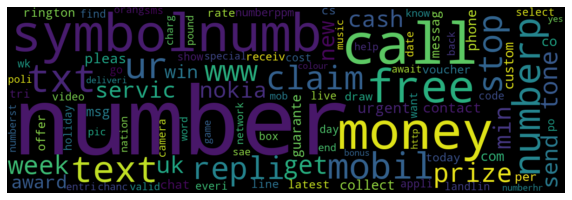

In [23]:
#Showing the  100 most used word in spam emails
wc = WordCloud(width=1200, height=400, max_words=200).generate_from_frequencies(spam_words.to_dict())

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
#Searching  the 100 most frequent words in ham emails

df_ham=count_words[count_words['label']==0].sum()
df_ham.sort_values(ascending=False,inplace=True)
df_ham.drop('label',inplace=True)
ham_words=df_ham.iloc[0:100]

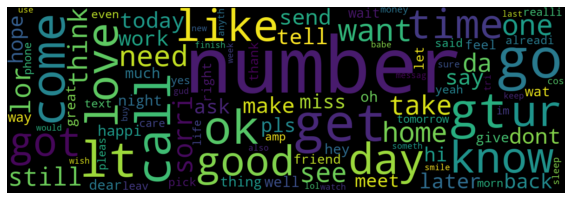

In [25]:
#Showing the  100 most used word in ham emails
wc = WordCloud(width=1200, height=400, max_words=200).generate_from_frequencies(ham_words.to_dict())

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

After that I searched the most used words for each category ,i will create a Bag of Word only with  that in order to reduce the number of variable that the model should  to handle

In [26]:
#columns to maintain
col= [*spam_words.index,*ham_words.index]
print(len(col))
#removing duplicate word
col = [*set(col)]
print(len(col))


200
180


In [27]:
#filtering columns from count_words dataframe
count_words=count_words[col]
count_words.shape


(5572, 180)

In [28]:
count_words['length']=data['length']
count_words['label']=data['class_label']

In [29]:
count_words.shape

(5572, 182)

## Term Frequency-Inverse Document Frequency

Next, we will implement an NLP technique—term frequency-inverse document frequency—to evaluate how important words are in the text data. In short, this technique simply defines what a “relevant word” is.

This technique is an improvement of the count vectors, and is widely used in the search technologies. Tf-Idf stands for Term frequency-Inverse document frequency. It tends to capture :

- **Tf** How frequently a word/term Wi appears in a document dj . This expression can be mathematically represented by Tf(Wi, dj)

- **Df** How frequently the same word/term appears across the entire corpus D. This expression can be mathematically represented by df(Wi, D).

- **Idf** measures how infrequently the word Wi occurs in the corpus D.

With that additional information, we can compute the Tf-Idf using the product of the tf and idf values

This technique doesn't consider the context of the word that can be a bad drawback

<a href="https://imgbb.com/"><img src="https://i.ibb.co/HhJXpGg/1-Xa-DXl8-ZCjeap-L0-0-Mm-Nln-Q.png" alt="1-Xa-DXl8-ZCjeap-L0-0-Mm-Nln-Q" border="0"></a>

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(sms_df)
print(tfidf_vec.shape)

tfidf_data=pd.DataFrame(tfidf_vec.toarray(),columns=tfidf_model.get_feature_names_out())
tfidf_data.head()

(5572, 6549)


,____,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,únumber,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
tfidf_vec.shape

(5572, 6549)

# Splitting data

Since i will use K-fold cross validation i don't need to split dataset ,i need only:

- X dataset
- Y dataset

In [32]:
data.columns

Index(['Category', 'Message', 'length', 'class_label'], dtype='object')

In [33]:
X= data['length']
Y=data['class_label']

X1=count_words.drop('label',axis=1)


In [34]:
X=pd.concat([X,tfidf_data],axis=1)

In [35]:
X.head()

,length,____,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,únumber,〨ud
0,111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X1.head()

,right,cost,mob,work,think,numberst,prize,collect,nation,select,...,like,wk,babe,co,bonus,gud,code,morn,tomorrow,length
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,111
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,155
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61


# Model Building
i will use a series of model:
- Random Forest
- Logistic Regression
- XGBoost

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [38]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X,Y,cv=5)
print(cv)
print(cv.mean())

[0.88520179 0.86726457 0.88240575 0.87701975 0.87971275]
0.8783209216575022


In [39]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X1,Y,cv=5)
print(cv)
print(cv.mean())

[0.94887892 0.95336323 0.95960503 0.95870736 0.9551167 ]
0.9551342473693957


In [ ]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X,Y,cv=5)
print(cv)
print(cv.mean())

In [ ]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X1,Y,cv=5)
print(cv)
print(cv.mean())

In [ ]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X,Y,cv=5)
print(cv)
print(cv.mean())

In [ ]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X1,Y,cv=5)
print(cv)
print(cv.mean())

In [ ]:
svc = SVC()
cv = cross_val_score(svc,X,Y,cv=5)
print(cv)
print(cv.mean())

In [ ]:
svc = SVC()
cv = cross_val_score(svc,X1,Y,scoring='accuracy',cv=5)
print(cv)
print(cv.mean())

In [ ]:


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(rf,X1,Y, cv=5)
confusion_matrix(Y,y_pred)


At this point before moving on we should choose the model to tune,i think since that an email classified as spam will go directly in spam folder we want the best classifier that is able to recognize a non spam email 

# Tuning the model